### Imports libraries

In [255]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as ss


### Path

In [256]:
current_dir = os.getcwd()
project_dir = os.path.dirname(current_dir)
data_raw_path = os.path.join(project_dir, 'data', 'raw')

### Helper Function

In [ ]:
def chi_squared_test(df, col1, col2, significance_level=0.05):
    # Create a contingency table
    contingency_table = pd.crosstab(df[col1], df[col2])

    # Perform chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Print results
    print(f"Chi-square statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print("Expected frequencies table:")
    print(expected)

    # Check correlation based on p-value
    if p < significance_level:
        print("There is a significant association between the two variables.")
    else:
        print("There is no significant association between the two variables.")
        
        
def cramers_corrected_stat(data, col1, col2):
    '''
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher, 
    Journal of the Korean Statistical Society 42 (2013): 323-328

    Parameters
    ----------
    confusion_matrix : DataFrame
        Pandas crosstab product between categorical.

    Returns
    -------
    int
        correlation which closer to 1 is correlate.

    '''
    cm_ = pd.crosstab(data[col1], data[col2]).to_numpy()
    chi2 = ss.chi2_contingency(cm_)[0]
    n = cm_.sum()
    phi2 = chi2/n
    r,k = cm_.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    
    result = np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    
    print(f"There is a {result} significant association between the two variables.")

# Introduction
We are looking at cold call results. Turns out, same salespeople called existing insurance customers up and tried to sell car insurance.

*Goals?* To predict the success of cold call results (Classifcation)

# Data Collection / Data Loading

In [257]:
for root, files, files in os.walk(data_raw_path):
    csv_files = {}
    for file in files:
        if "csv" in file:
            file_path = os.path.join(root, file)
            print(file)
            read_file = pd.read_csv(file_path)
            csv_files[file] = read_file

carInsurance_test.csv
carInsurance_train.csv


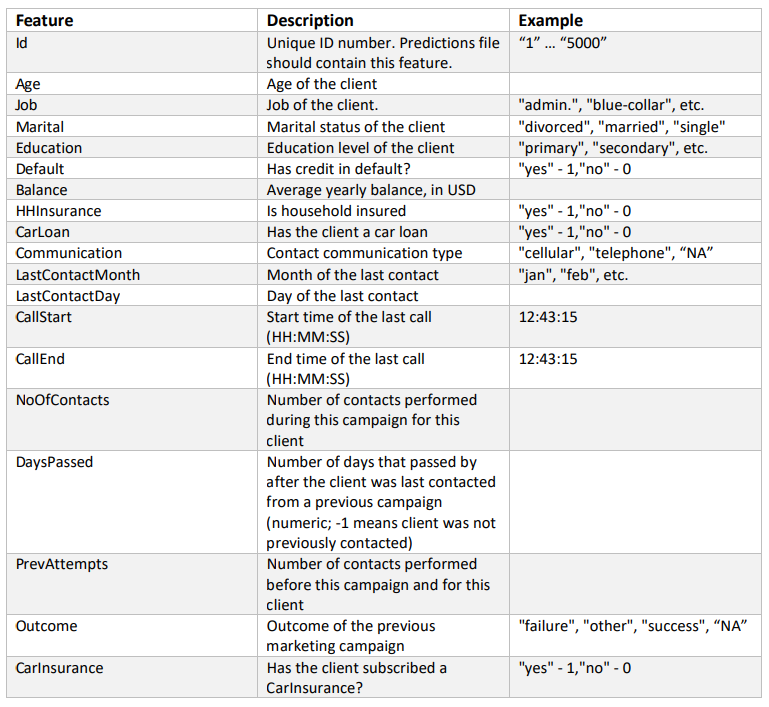


<div class="alert alert-block alert-info class">
  <b>Target:</b> Car Insurance
</div>

# Data Exploration

In [258]:
# manual extraction
df = csv_files['carInsurance_train.csv']
df

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,1,32,management,single,tertiary,0,1218,1,0,telephone,28,jan,2,-1,0,NaN,13:45:20,13:46:30,0
1,2,32,blue-collar,married,primary,0,1156,1,0,NaN,26,may,5,-1,0,NaN,14:49:03,14:52:08,0
2,3,29,management,single,tertiary,0,637,1,0,cellular,3,jun,1,119,1,failure,16:30:24,16:36:04,1
3,4,25,student,single,primary,0,373,1,0,cellular,11,may,2,-1,0,NaN,12:06:43,12:20:22,1
4,5,30,management,married,tertiary,0,2694,0,0,cellular,3,jun,1,-1,0,NaN,14:35:44,14:38:56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3996,28,technician,single,tertiary,0,0,1,0,cellular,25,may,1,40,2,failure,17:46:28,17:50:57,1
3996,3997,49,admin.,divorced,secondary,0,124,1,1,cellular,29,jul,19,-1,0,NaN,14:49:16,14:51:21,0
3997,3998,27,admin.,single,secondary,0,-400,0,1,cellular,8,jul,1,-1,0,NaN,12:19:03,12:23:53,0
3998,3999,36,entrepreneur,single,tertiary,0,658,1,0,cellular,29,jan,1,227,3,failure,11:27:35,11:29:14,0


### Findings:
1. There are missing data. Most concerning is 'Outcome'

In [259]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                4000 non-null   int64 
 1   Age               4000 non-null   int64 
 2   Job               3981 non-null   object
 3   Marital           4000 non-null   object
 4   Education         3831 non-null   object
 5   Default           4000 non-null   int64 
 6   Balance           4000 non-null   int64 
 7   HHInsurance       4000 non-null   int64 
 8   CarLoan           4000 non-null   int64 
 9   Communication     3098 non-null   object
 10  LastContactDay    4000 non-null   int64 
 11  LastContactMonth  4000 non-null   object
 12  NoOfContacts      4000 non-null   int64 
 13  DaysPassed        4000 non-null   int64 
 14  PrevAttempts      4000 non-null   int64 
 15  Outcome           958 non-null    object
 16  CallStart         4000 non-null   object
 17  CallEnd       

### Findings:
1. Balance : With negative min value

In [260]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,4000.0,2000.50000,1154.844867,1.0,1000.75,2000.5,3000.25,4000.0
Age,4000.0,41.21475,11.550194,18.0,32.00,39.0,49.00,95.0
Default,4000.0,0.01450,0.119555,0.0,0.00,0.0,0.00,1.0
Balance,4000.0,1532.93725,3511.452489,-3058.0,111.00,551.5,1619.00,98417.0
HHInsurance,4000.0,0.49275,0.500010,0.0,0.00,0.0,1.00,1.0
CarLoan,4000.0,0.13300,0.339617,0.0,0.00,0.0,0.00,1.0
LastContactDay,4000.0,15.72125,8.425307,1.0,8.00,16.0,22.00,31.0
NoOfContacts,4000.0,2.60725,3.064204,1.0,1.00,2.0,3.00,43.0
DaysPassed,4000.0,48.70650,106.685385,-1.0,-1.00,-1.0,-1.00,854.0
PrevAttempts,4000.0,0.71750,2.078647,0.0,0.00,0.0,0.00,58.0


In [261]:
# lets check test sets
dft = csv_files['carInsurance_test.csv']
dft

,Id,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,Communication,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,Outcome,CallStart,CallEnd,CarInsurance
0,4001,25,admin.,single,secondary,0,1,1,1,NaN,12,may,12,-1,0,NaN,17:17:42,17:18:06,NaN
1,4002,40,management,married,tertiary,0,0,1,1,cellular,24,jul,1,-1,0,NaN,09:13:44,09:14:37,NaN
2,4003,44,management,single,tertiary,0,-1313,1,1,cellular,15,may,10,-1,0,NaN,15:24:07,15:25:51,NaN
3,4004,27,services,single,secondary,0,6279,1,0,cellular,9,nov,1,-1,0,NaN,09:43:44,09:48:01,NaN
4,4005,53,technician,married,secondary,0,7984,1,0,cellular,2,feb,1,-1,0,NaN,16:31:51,16:34:22,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4996,31,admin.,single,secondary,0,131,1,0,cellular,15,jun,1,-1,0,NaN,13:54:24,13:56:55,NaN
996,4997,52,management,married,tertiary,0,2635,0,0,cellular,6,sep,1,108,8,success,13:13:38,13:18:51,NaN
997,4998,46,technician,married,tertiary,0,3009,0,0,cellular,4,aug,2,-1,0,NaN,10:23:35,10:24:33,NaN
998,4999,60,retired,married,secondary,0,7038,0,0,telephone,7,oct,4,-1,0,NaN,17:01:49,17:04:07,NaN


In [262]:
# similiar with train sets
dft.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1000 non-null   int64  
 1   Age               1000 non-null   int64  
 2   Job               995 non-null    object 
 3   Marital           1000 non-null   object 
 4   Education         953 non-null    object 
 5   Default           1000 non-null   int64  
 6   Balance           1000 non-null   int64  
 7   HHInsurance       1000 non-null   int64  
 8   CarLoan           1000 non-null   int64  
 9   Communication     779 non-null    object 
 10  LastContactDay    1000 non-null   int64  
 11  LastContactMonth  1000 non-null   object 
 12  NoOfContacts      1000 non-null   int64  
 13  DaysPassed        1000 non-null   int64  
 14  PrevAttempts      1000 non-null   int64  
 15  Outcome           243 non-null    object 
 16  CallStart         1000 non-null   object 
 

### Findings Continous Variable:
1. Age : Positive Skewed
2. Balance : Positive Skewed

In [263]:
# Helper function
def boxHist_con(data, con):
    #--Categorical variable--#
    if data[con].isna().sum() == 0:
        print(f'{con} missing data :{data[con].isna().sum()}')
    else:
        print(f'{con} missing data :{data[con].isna().sum()} ({data[con].isna().sum()/len(data) * 100} %)')

    # Cut the window in 2 parts
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})

    # Create a box plot on top
    sns.boxplot(data=data, x=con, ax=ax_box)
    # Remove x axis name for the boxplot
    ax_box.set(xlabel='')

    # Create a histogram on bottom
    sns.histplot(data=data, x=con, ax=ax_hist, kde=True)

    # Show the plot
    plt.show()

Age missing data :0


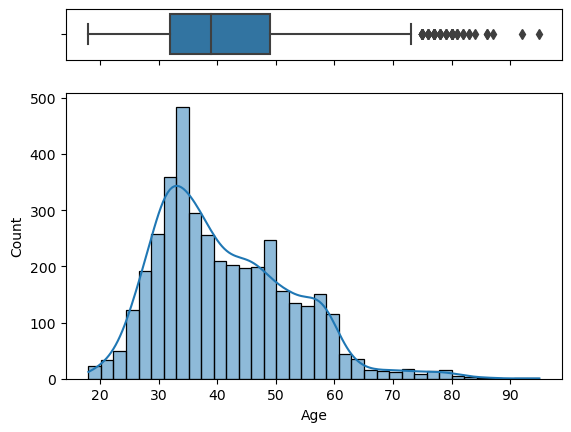

In [264]:
#--Age--#
boxHist_con(df, 'Age')

Balance missing data :0


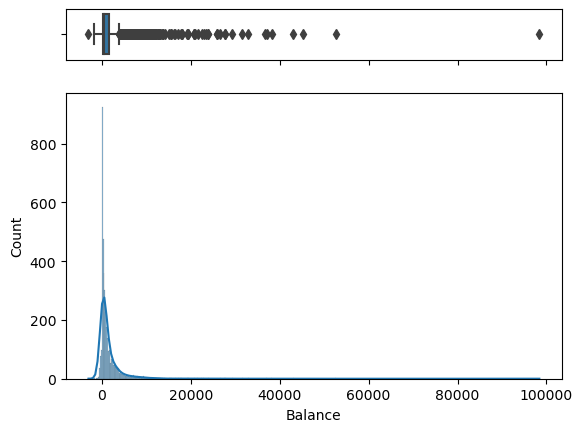

In [265]:
#--Balance--#
boxHist_con(df, 'Balance')

CallDuration missing data :0


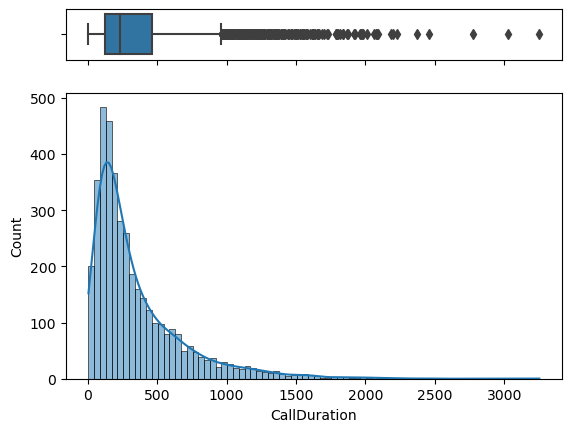

In [266]:
#--Call Duration--#
df['CallStart'] = pd.to_datetime(df['CallStart'], format='%H:%M:%S')
df['CallEnd'] = pd.to_datetime(df['CallEnd'], format='%H:%M:%S')

# need to be in pipeline
# Calculate call duration and create a new column 'CallDuration'
df['CallDuration'] = df['CallEnd'] - df['CallStart']
df['CallDuration'] = df['CallDuration'].dt.total_seconds()

boxHist_con(df, 'CallDuration')

NoOfContacts missing data :0


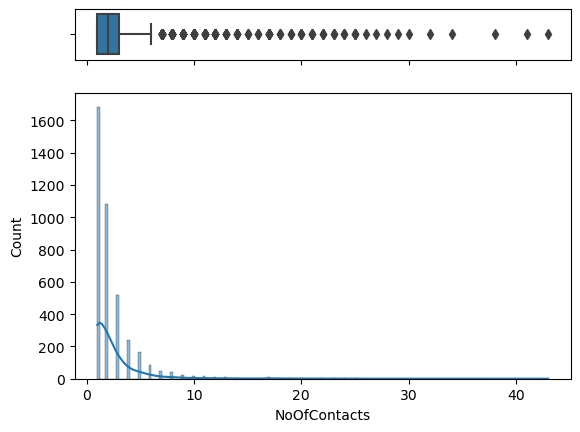

In [285]:
#--DaysPassed--#
boxHist_con(df, 'NoOfContacts')

DaysPassed missing data :0


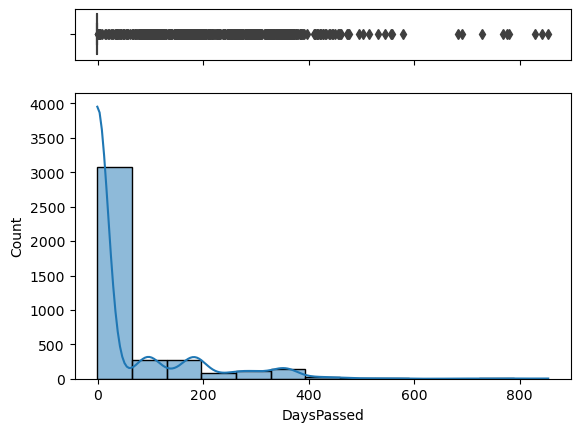

In [267]:
#--DaysPassed--#
boxHist_con(df, 'DaysPassed')

### Findings Categorical Variable
1. Outcome : Lots of missing data

CarInsurance missing data :0


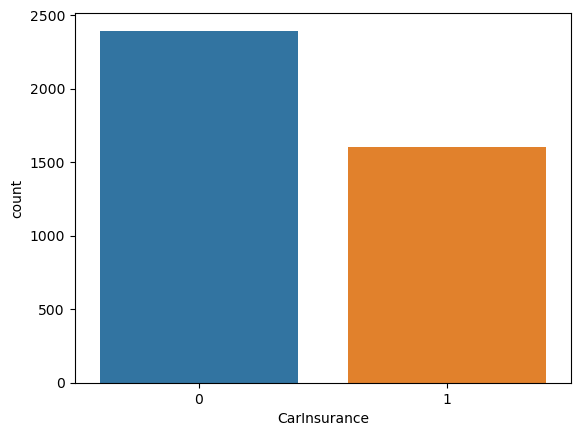

In [268]:
#--CarInsurance--#
print(f'CarInsurance missing data :{df.CarInsurance.isna().sum()}')

sns.countplot(data=df, x='CarInsurance')
plt.show()

In [269]:
# Helper function
def count_cat(data, cat, target):
    #--Variable to check--#
    if data[cat].isna().sum() != 0:
        print(f'{cat} missing data :{data[cat].isna().sum()} ({data[cat].isna().sum()/len(data) * 100} %)')
    else:
        print(f'{cat} missing data :{data[cat].isna().sum()}')

    sns.countplot(data=data, y=cat, hue=target)
    plt.show()

Outcome missing data :3042 (76.05 %)


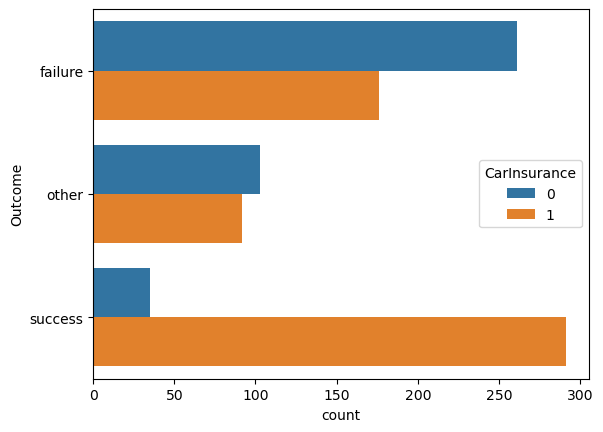

In [270]:
#--Outcome--#
count_cat(df, 'Outcome', 'CarInsurance')

Outcome_Simplify missing data :0


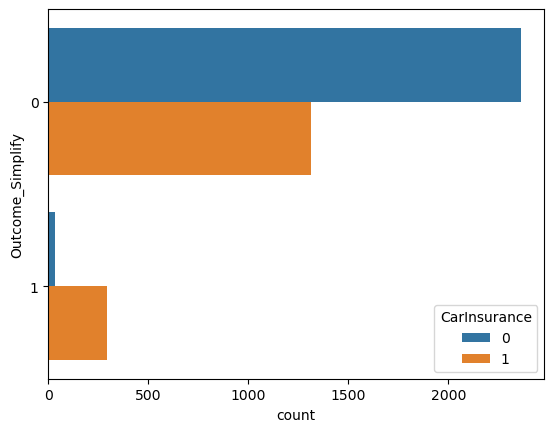

In [283]:
df['Outcome_Simplify'] = df['Outcome'].apply(lambda x: 1 if x=='success' else 0)

#--Outcome Simplify--#
count_cat(df, 'Outcome_Simplify', 'CarInsurance')

PrevAttempts missing data :0


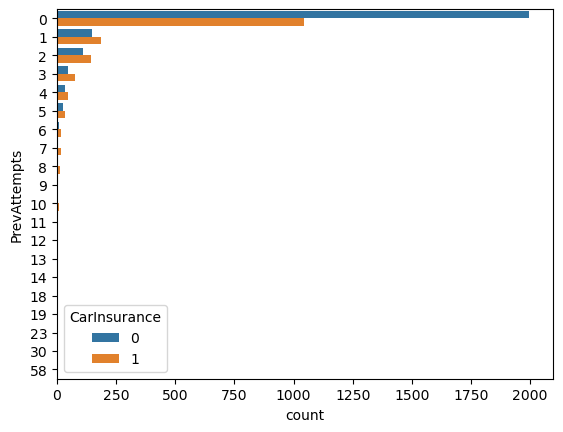

In [275]:
#--PrevAttempts--#
count_cat(df, 'PrevAttempts', 'CarInsurance')

PrevAttemp_Simplify missing data :0


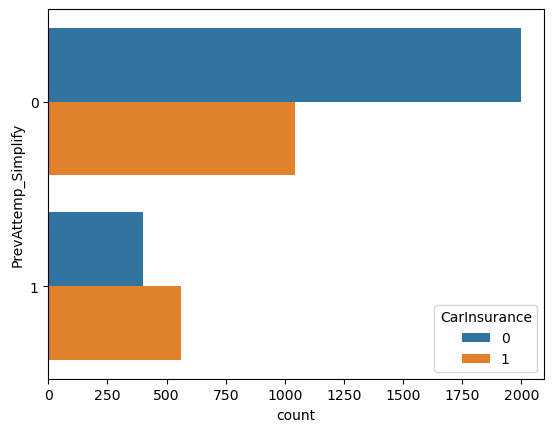

In [276]:
# simplifying PrevAttempts
df['PrevAttemp_Simplify'] = df['PrevAttempts'].apply(lambda x: 1 if x > 0 else 0)

# need to be in pipeline
count_cat(df, 'PrevAttemp_Simplify', 'CarInsurance')

LastContactDay missing data :0


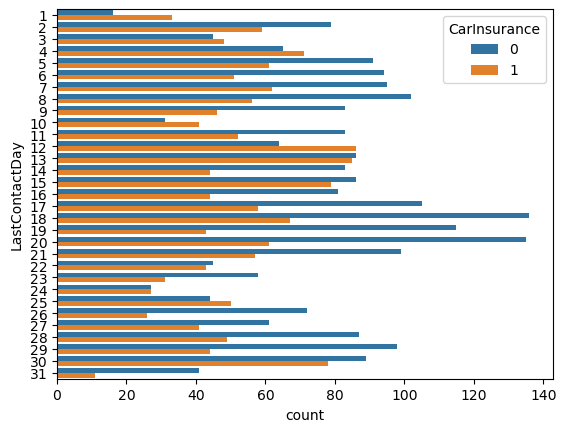

In [277]:
#--LastContactDay--#
count_cat(df, 'LastContactDay', 'CarInsurance')

LastContactMonth missing data :0


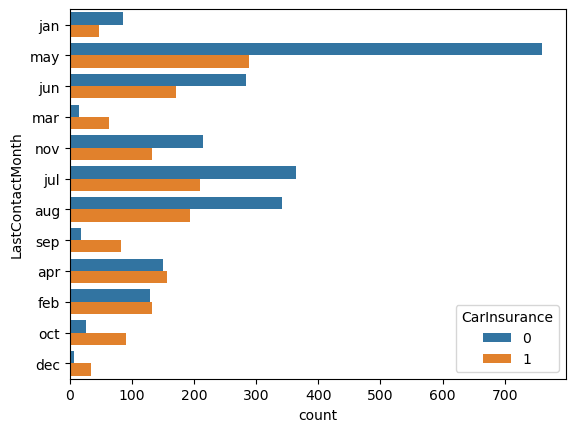

In [278]:
#--LastContactMonth--#
count_cat(df, 'LastContactMonth', 'CarInsurance')

Communication missing data :902 (22.55 %)


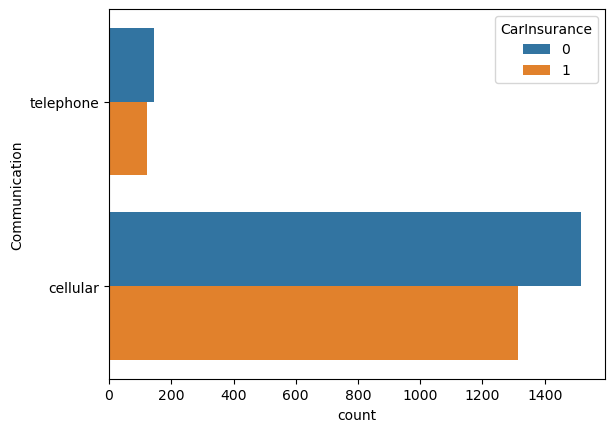

In [286]:
#--Communication--#
count_cat(df, 'Communication', 'CarInsurance')

Communication_refined missing data :0


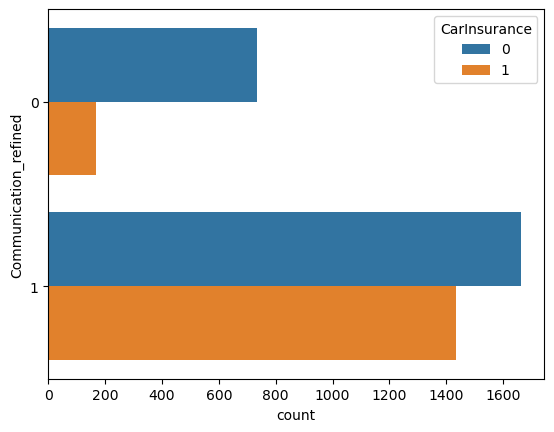

In [288]:
#--Communication--#
# need to be in pipeline
df['Possessed_Com_Device'] = df['Communication'].fillna('No Communication')
df['Possessed_Com_Device'] = df['Possessed_Com_Device'].apply(lambda x: 0 if x == 'No Communication' else 1)
count_cat(df, 'Possessed_Com_Device', 'CarInsurance')

CarLoan missing data :0


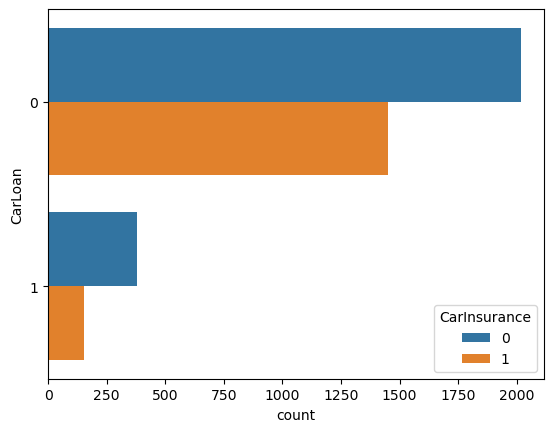

In [289]:
#--CarLoan--#
count_cat(df, 'CarLoan', 'CarInsurance')

HHInsurance missing data :0


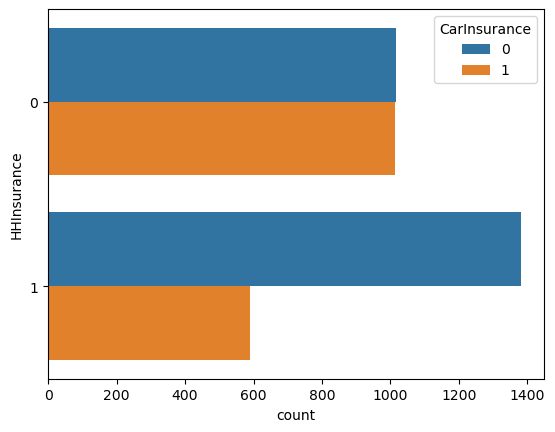

In [290]:
#--HHInsurance--#
count_cat(df, 'HHInsurance', 'CarInsurance')

Default missing data :0


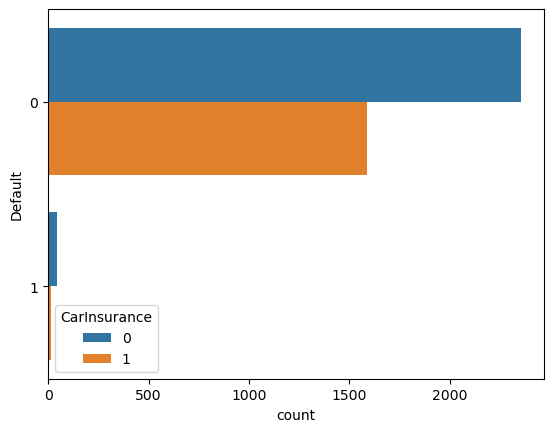

In [291]:
#--Default--#
count_cat(df, 'Default', 'CarInsurance')

Education missing data :169 (4.2250000000000005 %)


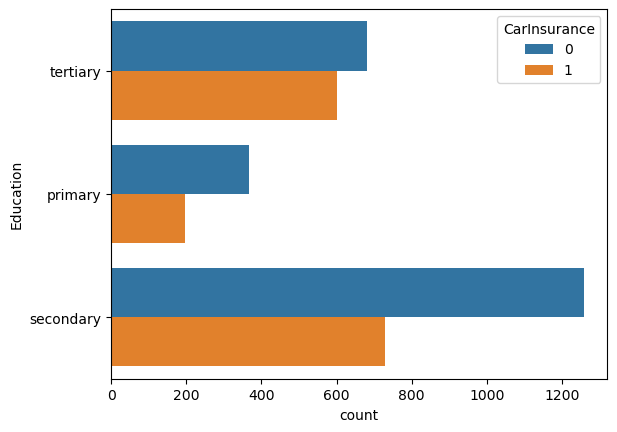

In [292]:
#--Education--#
count_cat(df, 'Education', 'CarInsurance')

Education_refined missing data :0


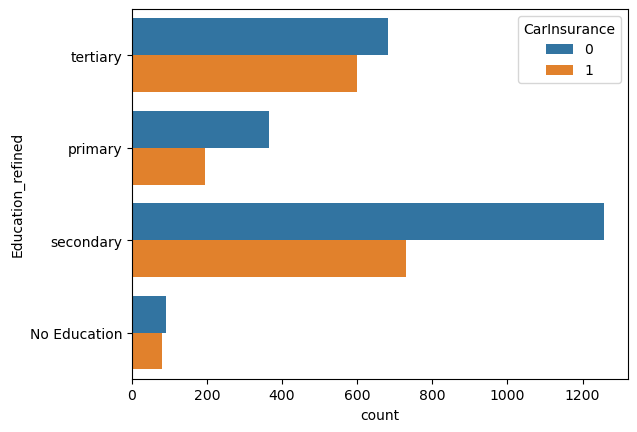

In [293]:
#--Education--#
# need to be in pipeline
df['Education_refined'] = df['Education'].fillna('No Education')
count_cat(df, 'Education_refined', 'CarInsurance')

Marital missing data :0


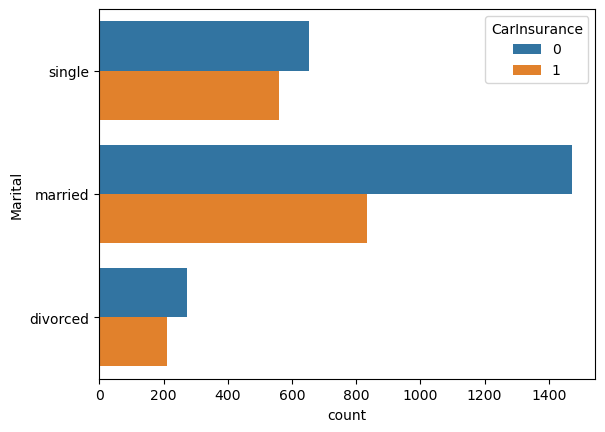

In [295]:
#--Marital--#
count_cat(df, 'Marital', 'CarInsurance')

Job missing data :19 (0.475 %)


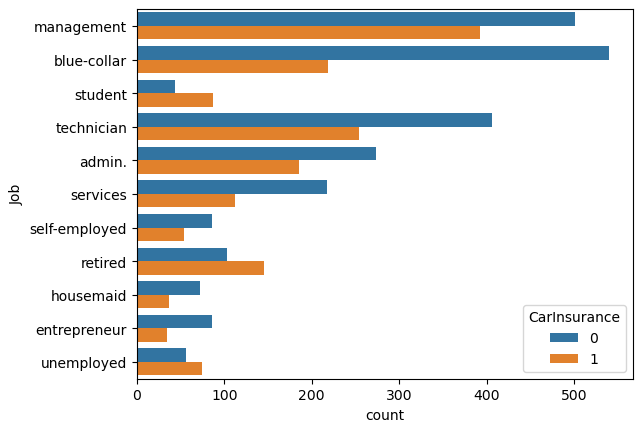

In [279]:
#--Job--#
count_cat(df, 'Job', 'CarInsurance')

Job_refined missing data :0


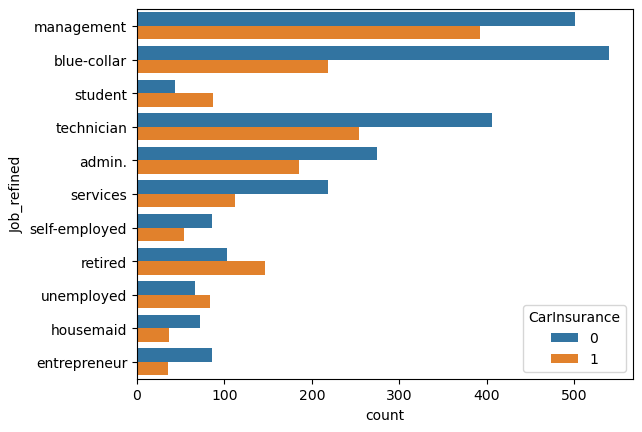

In [296]:
#--Job--#
df['Job_refined'] = df['Job'].fillna('unemployed')
count_cat(df, 'Job_refined', 'CarInsurance')